# Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform_geom, calculate_default_transform, Resampling
import shapely 
from shapely.ops import unary_union
from shapely import box
#from skimage.measure import block_reduce

In [2]:
from data.config import CONFIG
from utilities.area import EARTH_RADIUS, show_stats, get_scales
from utilities.geojson import filter_features_by_list, get_polygons, convert_dict_to_shapely
from utilities.plotting import (
    get_projection_xticks, get_projection_yticks,
    plot_polygon_transform, plot_polygons_transform,
    plot_polygon, plot_polygons
)

In [3]:
data_dir = r'../../datasets/geospatial'

## Functions

In [4]:
def calc_centre(polygons: dict):
    polygon_border = shapely.unary_union(list(polygons.values()))
    long_min, lat_min, long_max, lat_max = polygon_border.bounds
    long_avg = (long_min + long_max) / 2
    lat_avg = (lat_max + lat_min) / 2
    return (long_avg, lat_avg)

def calc_square_boundary(polygons: dict, length: float):
    polygon_border = shapely.unary_union(list(polygons.values()))
    # centre
    long_min, lat_min, long_max, lat_max = polygon_border.bounds
    long_avg = (long_min + long_max) / 2
    lat_avg = (lat_max + lat_min) / 2
    # units
    half_length = length / 2
    lat_unit = half_length / radius * (180 / np.pi)
    long_unit = half_length / (radius * np.cos(lat_avg * np.pi / 180)) * (180 / np.pi)
    print(f"Longitude range: {long_max - long_min:.4f}°")
    print(f"Latitude range:  {lat_max - lat_min:.4f}°")
    print(f"Longitude unit:  {long_unit:.4f}°")
    print(f"Latitude unit:   {lat_unit:.4f}°")
    new_bounds = (long_avg - long_unit, lat_avg - lat_unit, long_avg + long_unit, lat_avg + lat_unit)
    return new_bounds

def transverse_mercator_projection(polygons: dict, long: float):
    dst_src = {
        'proj': 'tmerc',
        'lat_0': 0,
        'lon_0': long,
        'k': 1/1000, # convert to km
        'x_0': 0,
        'y_0': 0,
        'ellps': 'WGS84',
        'units': 'm',
        'no_defs': True
    }
    src_crs = rasterio.crs.CRS.from_epsg(4326)
    polygons_dst = transform_geom(
        src_crs,
        dst_src,
        polygons.values()
    )
    polygons_dst = {
        name: convert_dict_to_shapely(geom) for name, geom in zip(polygons.keys(), polygons_dst)
    }
    return polygons_dst, dst_src

## Plotting

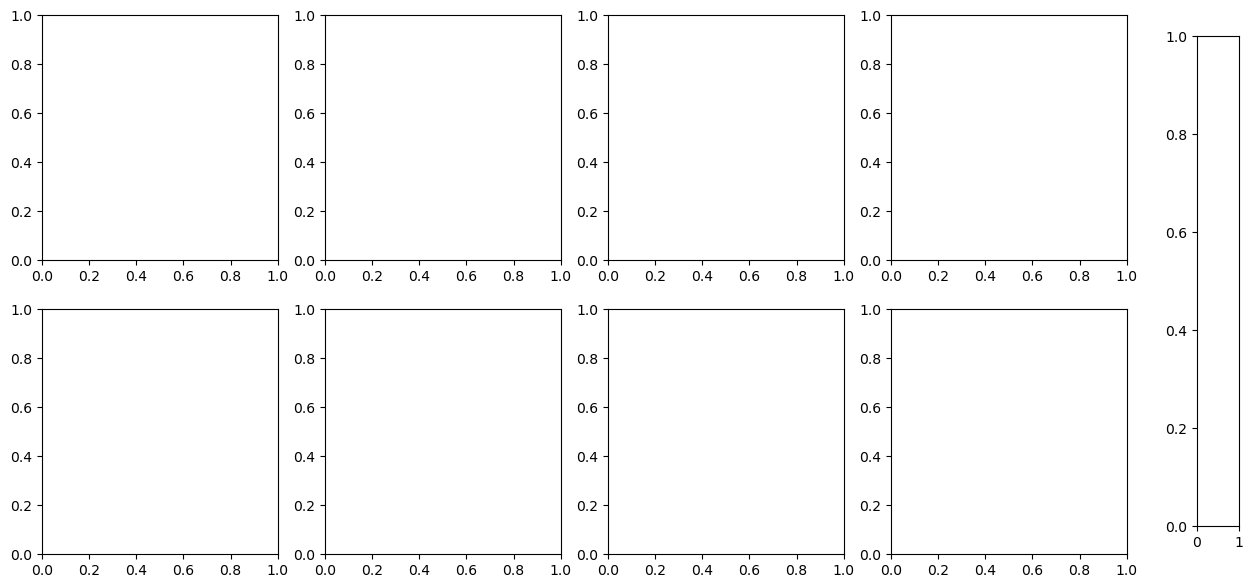

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 7));
images = [[np.zeros((1, 1)) for j in range(4)] for i in range(2)]
cbar_axis = fig.add_axes([0.95, 0.15, 0.03, 0.7])
scale = "log"
vmax = 1000
if scale == "log":
    vmax = np.log10(vmax)
cmap = plt.get_cmap('inferno')#, 10)
radius = EARTH_RADIUS
length = 60_000 # m

https://www.geoboundaries.org/countryDownloads.html 

https://data.metabolismofcities.org/dashboards/johannesburg/hub/harvesting/852/

In [17]:
configs = [
    ('United States', "New York"),
    ("United Kingdom", "London"),
    #('Gaza', "Gaza City"),
    ("France", "Paris"),
    ("South Korea", "Seoul"),
    ("Egypt", "Greater Cairo"),
    ("India", "Mumbai"),
    ("Bangladesh", "Dhaka"),
    ("Phillipines", "Manila"),
]

In [7]:
idx = -1

### Loop

In [47]:
idx += 1

In [48]:
country, city = configs[idx]
city_ = "London" if city == "London Boroughs" else city
region_name = f"{city_}, {country}"
print(region_name)
config = CONFIG[country]
feature_names = [props[0] for props in config["features"][city]]
geojson_filepath = os.path.join(data_dir, 'borders', config["geojson filepath"])
raster_filepath = os.path.join(data_dir, 'rasters', config["raster filepath"])
prop_name = 'shapeID'
keep_top = -1
i, j = idx // 4, idx % 4
print(f"({i}, {j})")
ax = axes[i][j]

Manila, Phillipines
(1, 3)


In [49]:
print(f"Loading features from {geojson_filepath} ...", end =" ")
with open(geojson_filepath, 'r') as f:
    shape_data = json.load(f)
    if feature_names is None:
        features = shape_data['features']
    else:
        features = filter_features_by_list(shape_data, prop_name, feature_names)
        assert len(feature_names) == len(features)
print("done.")
print("Loading Shapely polygons ...", end=" ")
admin_polygons = get_polygons(features, identifier=prop_name)
print("done.")
border_polygon = unary_union(list(admin_polygons.values()))
long_min, lat_min, long_max, lat_max = border_polygon.bounds
long_avg = (long_min + long_max) /2 
polygons_proj, crs_proj = transverse_mercator_projection(admin_polygons, long_avg)
border_proj, _ = transverse_mercator_projection({'region': border_polygon}, long_avg)
print(f"Projected geometries onto {crs_proj}.")

Loading features from ../../datasets/geospatial\borders\geoBoundaries-PHL-ADM2-all/geoBoundaries-PHL-ADM2.geojson ... done.
Loading Shapely polygons ... done.
Projected geometries onto {'proj': 'tmerc', 'lat_0': 0, 'lon_0': 121.02071592300007, 'k': 0.001, 'x_0': 0, 'y_0': 0, 'ellps': 'WGS84', 'units': 'm', 'no_defs': True}.


In [50]:
degree_bounds = calc_square_boundary(admin_polygons, length=length)
print(f"boundary: {degree_bounds}")
boundary = box(*degree_bounds)
with rasterio.open(raster_filepath) as src:
    img_region, transform_region = rasterio.mask.mask(src, [boundary], crop=True)
    img_region[img_region < 0] = 0
    crs_src = src.crs
print(f"Image dimensions: {img_region.shape}")
print(f"Total population:    {img_region.sum():>13,.2f}")
print(f"Maximum pixel count: {img_region.max():>12,.2f}")
print(f"Pixel mean count:    {img_region.mean():>12,.2f}")
print("")

print("Calculating transform ...", end=" ")
transform_proj, width_proj, height_proj = calculate_default_transform(
    crs_src, crs_proj, img_region.shape[2], img_region.shape[1], *boundary.bounds)
print("done.\n")

print("Projecting image ...", end=" ")
img_proj = np.zeros((height_proj, width_proj))
rasterio.warp.reproject(
    source=img_region[0, :, :],
    destination=img_proj,
    src_transform=transform_region,
    src_crs=crs_src,
    dst_transform=transform_proj,
    dst_crs=crs_proj,
    resampling=Resampling.bilinear
)
images[i][j] = img_proj
print("done.\n")

# Plot
print("Plotting")
ax.clear()
ax.set_title(f'{region_name}');
if scale == "log":
    axis_image = ax.imshow(np.log10(img_proj + 1), vmax=vmax, cmap=cmap)
    #axis_image = ax.imshow(np.log10(img_region[0, :, :] + 1), vmax=vmax, cmap=cmap)
else:
    axis_image = ax.imshow(img_proj, vmax=vmax, cmap=cmap)
    #axis_image = ax.imshow(img_region[0, :, :], vmax=vmax, cmap=cmap)
plot_polygons_transform(ax, border_proj.values(), transform_proj.__invert__(), 'w-', linewidth=1.0)
#plot_polygons_transform(ax, [region_polygon], transform_region.__invert__(), linewidth=1.0)
# Labels
x_ticks, x_ticklabels = get_projection_xticks(transform_proj, width_proj, height_proj, step_size=20)
y_ticks, y_ticklabels = get_projection_yticks(transform_proj, width_proj, height_proj, step_size=10)
y_ticklabels -= y_ticklabels[0]
xticklabels = x_ticklabels if i == 1 else []
yticklabels = y_ticklabels if j == 0 else []
ax.set_xticks(x_ticks, xticklabels);
ax.set_yticks(y_ticks, yticklabels);

Longitude range: 0.2286°
Latitude range:  0.4336°
Longitude unit:  0.2788°
Latitude unit:   0.2698°
boundary: (120.74195696542654, 14.298714471126726, 121.2994748805736, 14.838306824873388)
Image dimensions: (1, 649, 670)
Total population:    21,198,542.00
Maximum pixel count:    13,468.65
Pixel mean count:           48.75

Calculating transform ... done.

Projecting image ... done.

Plotting


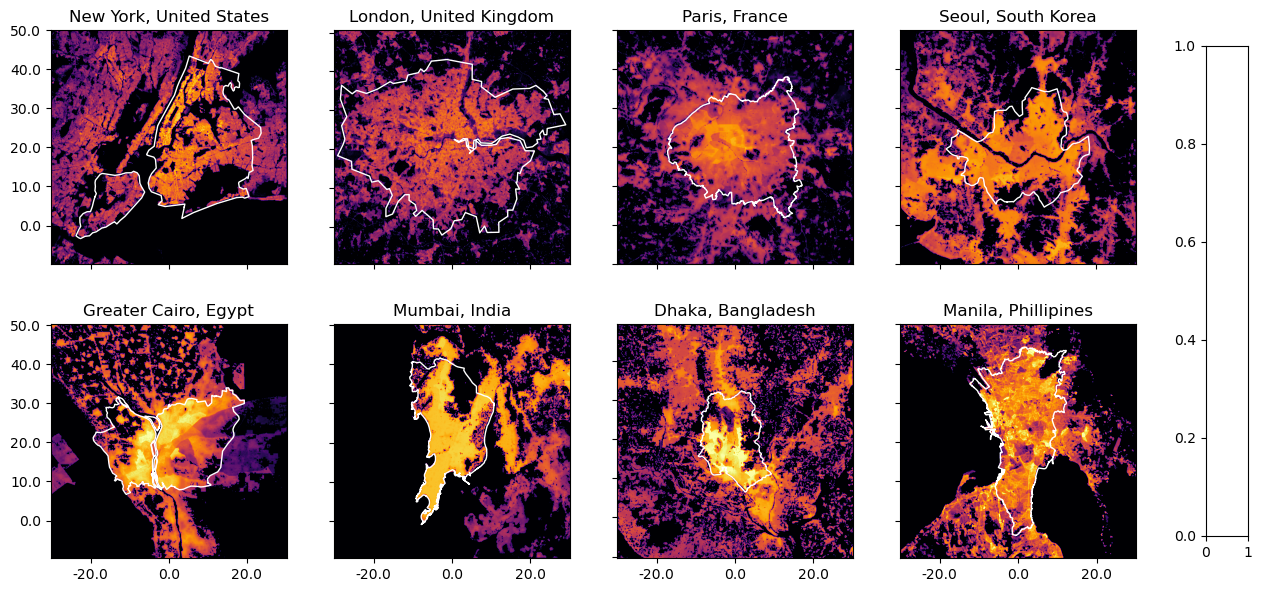

In [51]:
fig

### Axis attributes

In [ ]:
cmap = plt.get_cmap('inferno')
vmax = 1000
scale = "log"
if scale == "log":
    vmax = np.log10(vmax)
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i][j]
        for axis_image in ax.get_images():
            axis_image.set_cmap(cmap)
            #axis_image = ax.imshow(images[i][j], vmax=vmax, cmap=cmap)
            #axis_image = ax.imshow(np.log10(images[i][j] + 1), vmax=vmax, cmap=cmap)
fig

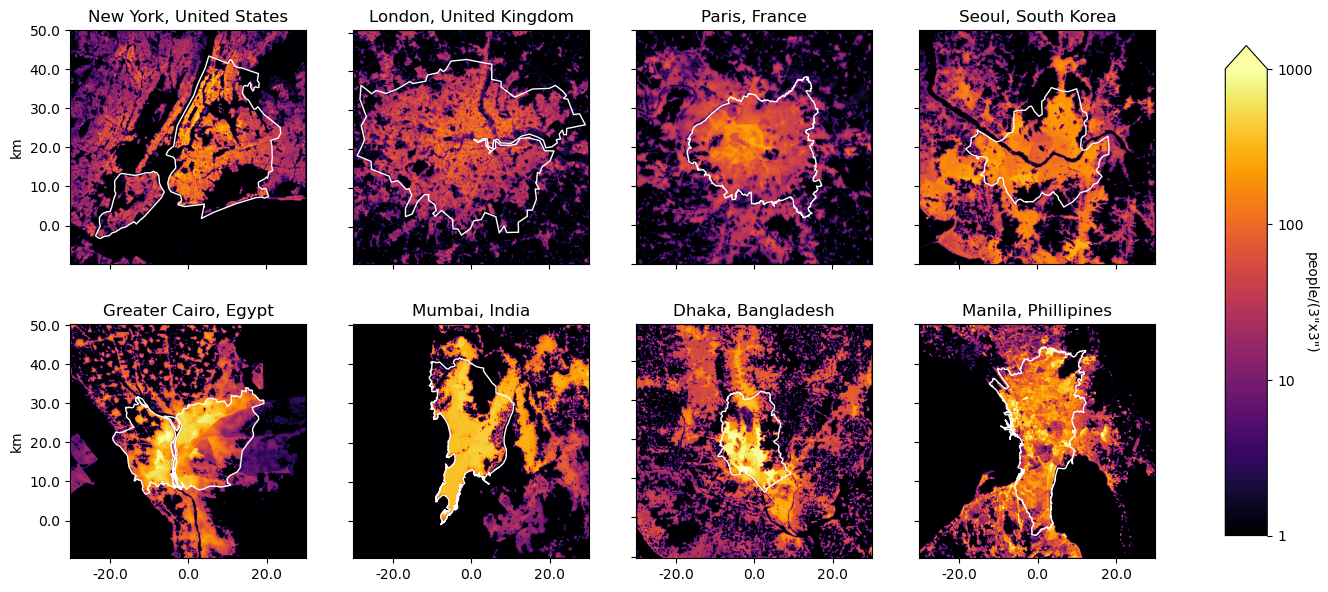

In [56]:
cbar_axis.clear()
cbar_axis.set_xticks([])
cbar_axis.set_yticks([])

cbar = fig.colorbar(axis_image, cax=cbar_axis, extend='max')
cbar.set_label('people/(3\"x3\")', rotation=270) # counts
if scale == "log":
    ticks = np.append(np.arange(vmax - 0.1), vmax)
    tick_labels = [f'{x:.0f}' for x in 10 ** ticks]
else:
    ticks = np.append(np.arange(0, vmax - 1, step=200), vmax)
    tick_labels = [f'{x:d}' for x in ticks]
cbar.ax.set_yticks(ticks);
cbar.ax.set_yticklabels(tick_labels);

axes[0][0].set_ylabel('km')
axes[1][0].set_ylabel('km')
fig

In [57]:
outpath = os.path.join('images', f"group_distribution_{cmap.name}_{scale}.png")
fig.savefig(outpath, bbox_inches="tight")
print(f"Saved figure to {outpath}")

Saved figure to images\group_distribution_inferno_log.png
